<a href="https://colab.research.google.com/github/KeeganMcWW/ml-projects/blob/main/IASIM2016_Challenege_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import and set up the Colab

In [1]:
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import numpy as np

from google.colab import files

In [47]:
%matplotlib inline

In [2]:
machine_data_path = r'/content/data_files/'
try:
    os.mkdir(machine_data_path)
except OSError:
      print ("Creation of the directory %s failed" % machine_data_path)
else:
    print ("Successfully created the directory %s " % machine_data_path)

Successfully created the directory /content/data_files/ 


In [3]:
!wget https://eigenvector.com/wp-content/uploads/2021/03/IASIM16ChallengeProblem.zip

--2021-10-11 01:50:26--  https://eigenvector.com/wp-content/uploads/2021/03/IASIM16ChallengeProblem.zip
Resolving eigenvector.com (eigenvector.com)... 69.163.163.60, 2607:f298:6:a034::eaf:812c
Connecting to eigenvector.com (eigenvector.com)|69.163.163.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448641963 (428M) [application/zip]
Saving to: ‘IASIM16ChallengeProblem.zip’

IASIM16ChallengePro 100%[===================>] 427.86M  31.8MB/s    in 14s     

2021-10-11 01:50:40 (31.7 MB/s) - ‘IASIM16ChallengeProblem.zip’ saved [448641963/448641963]



In [4]:
!unzip IASIM16ChallengeProblem.zip -d data_files

Archive:  IASIM16ChallengeProblem.zip
   creating: data_files/ForTheJudges/
  inflating: data_files/ForTheJudges/Hyperspectral_FACSS2011_NBGb.pdf  
  inflating: data_files/ForTheJudges/InformationForJudges.pdf  
  inflating: data_files/IASIM_2016_Challenge.pdf  
 extracting: data_files/M_200ppm.mat  
 extracting: data_files/Melamine_Pure.mat  
 extracting: data_files/Test_1.mat   
 extracting: data_files/Test_2.mat   
 extracting: data_files/Test_3.mat   
 extracting: data_files/Wheat_Gluten_Pure.mat  
   creating: data_files/__MACOSX/
  inflating: data_files/__MACOSX/._IASIM_2016_Challenge.pdf  
  inflating: data_files/__MACOSX/._M_200ppm.mat  
  inflating: data_files/__MACOSX/._Melamine_Pure.mat  
  inflating: data_files/__MACOSX/._Test_1.mat  
  inflating: data_files/__MACOSX/._Test_2.mat  
  inflating: data_files/__MACOSX/._Test_3.mat  
   creating: data_files/__MACOSX/ForTheJudges/
  inflating: data_files/__MACOSX/ForTheJudges/._Hyperspectral_FACSS2011_NBGb.pdf  
  inflating: data

### Helper functions

In [5]:
# https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], sio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, sio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, sio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = sio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

### Examining the Data

In [6]:
wheat_gluten_pure = loadmat('/content/data_files/Wheat_Gluten_Pure.mat')

Data is imported with as a dict with nestled dicts. The important dict is the 'z' dictionary, which contains the important information.

In [28]:
wheat_gluten_pure['z'].keys()

dict_keys(['name', 'type', 'author', 'date', 'moddate', 'imagesize', 'imagemode', 'data', 'label', 'axisscale', 'imageaxisscale', 'title', 'class', 'include', 'classlookup', 'axistype', 'imageaxistype', 'description', 'userdata', 'datasetversion', 'history', 'uniqueid'])

In [40]:
x_size, y_size = wheat_gluten_pure['z']['imagesize']
z_size = np.shape(wheat_gluten_pure['z']['data'])[1]
print(x_size, y_size, z_size)

243 244 229


In [88]:
data_mat = np.reshape(wheat_gluten_pure['z']['data'], (x_size, y_size, z_size), order = 'F')

lets take a look at the image. Here I am just slicing along the z axis. Each pixel is just the intensity at the given spectral point. For example, when z_slice = 0 we are looking at the reflectance instensity at 1120nm for the image. 

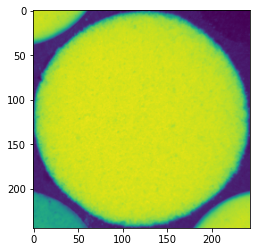

In [100]:
z_slice = 0 #@param {type: "slider", min: 0, max: 228}
plt.imshow(data_mat.T[z_slice][:][:])
plt.show()

No we can slice along one of the axis to check out the spectral data. Here I am slicing along the x axis. 

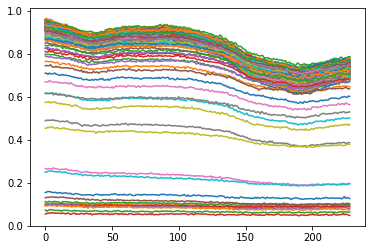

In [101]:
x_slice = 88 #@param {type: "slider", min: 0, max: 243}
plt.plot(data_mat[x_slice][:][:].T)
plt.show()